<a href="https://colab.research.google.com/github/RATFIVE/GEOMAR-DeepLearning/blob/main/app/backend/small-model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

## Clone the data from GitHub

In [2]:
import os
if not os.path.exists('GEOMAR-DeepLearning'):
    print(f'GEOMAR-DeepLearning does not exist')
    !git clone https://github.com/RATFIVE/GEOMAR-DeepLearning.git
    %cd GEOMAR-DeepLearning/app/backend
    !git pull
    !pip install -r requirements.txt
else:
    print(f'GEOMAR-DeepLearning exists')
    %cd GEOMAR-DeepLearning/app/backend
    !git pull
    !pip install -r requirements.txt

GEOMAR-DeepLearning exists
/content/GEOMAR-DeepLearning/app/backend
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (5/5), done.
Unpacking objects: 100% (5/5), 1.12 KiB | 57.00 KiB/s, done.
remote: Total 5 (delta 3), reused 0 (delta 0), pack-reused 0 (from 0)
From https://github.com/RATFIVE/GEOMAR-DeepLearning
   b0cb588..73a940f  main       -> origin/main
Updating b0cb588..73a940f
Fast-forward
 app/backend/small-model.ipynb | 3003 ++-----------------------------------------------------------
 1 file changed, 80 insertions(+), 2923 deletions(-)


## Import Libaries

In [3]:
# import all necessary libraries
import copy
import os
from PIL import Image
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from sklearn import metrics
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from torch import nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.tensorboard import SummaryWriter
import datetime
from utils.Copernicus import AdvancedCopernicus
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import warnings
from tqdm import tqdm
# Ignore SettingWithCopyWarning:
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)



# Display all columns
pd.options.display.max_columns = None
pd.options.display.max_rows = None

## Import Data

In [4]:
START_DATE = '2025-02-01'
END_DATE = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
OUTPUT_FILENAME = 'output.nc'

BBOX= {
    # "min_lon":10.038345850696412,
    # "max_lon":10.365962458698567,
    # "min_lat":54.27381478077755,
    # "max_lat":54.52976525577923,

    "minimum_longitude":9.85083510071235,
    "maximum_longitude":10.926709174713364,
    "minimum_latitude":54.25206332481298,
    "maximum_latitude":54.97306793985031,

    "target_min_lon":10.156,
    "target_max_lon":10.170,
    "target_min_lat":54.354,
    "target_max_lat":54.365
    }

In [5]:
copernicus = AdvancedCopernicus()
def load_ocean_data(variables=["bottomT", "mlotst", "siconc", "sithick", "sla", "so", "sob", "thetao", "uo", "vo", "wo"],
                    minimum_longitude=BBOX["minimum_longitude"],
                    maximum_longitude=BBOX["maximum_longitude"],
                    minimum_latitude=BBOX["minimum_latitude"],
                    maximum_latitude=BBOX["maximum_latitude"],
                    delete_file=True,
                    output_filename='output'):

    output_range = maximum_longitude - minimum_longitude
    output_filename = f'{output_filename}-{START_DATE}-{output_range}.nc'

    if os.path.exists(output_filename):
        print(f'File {output_filename} already exists')
        return output_filename

    data = copernicus.get_subset(
        dataset_id="cmems_mod_bal_phy_anfc_PT1H-i",
        dataset_version="202411",
        variables=variables,
        minimum_longitude=minimum_longitude,
        maximum_longitude=maximum_longitude,
        minimum_latitude=minimum_latitude,
        maximum_latitude=maximum_latitude,
        start_datetime=START_DATE,
        end_datetime=END_DATE,
        minimum_depth=0.5016462206840515,
        maximum_depth=0.5016462206840515,
        coordinates_selection_method="strict-inside",
        disable_progress_bar=False,
        output_filename=output_filename,
        delete_file=delete_file)

    return data.to_dataframe().reset_index()

training_data = load_ocean_data(
    variables=["bottomT", "mlotst", "siconc", "sithick", "sla", "so", "sob", "thetao", "uo", "vo", "wo"],
    minimum_longitude=BBOX["minimum_longitude"],
    maximum_longitude=BBOX["maximum_longitude"],
    minimum_latitude=BBOX["minimum_latitude"],
    maximum_latitude=BBOX["maximum_latitude"], delete_file=False, output_filename='training'
)

target_data = load_ocean_data(
    variables=["sla"],
    minimum_longitude=BBOX["target_min_lon"],
    maximum_longitude=BBOX["target_max_lon"],
    minimum_latitude=BBOX["target_min_lat"],
    maximum_latitude=BBOX["target_max_lat"], delete_file=False, output_filename='target'
)


# Check if training_data is a class str
if isinstance(training_data, str):
    # Read .nc file
    training_data = xr.open_dataset(training_data).to_dataframe().reset_index()
    print(f'Open Training Data as DataFrame')
else:
    print(f'Training Data is already a DataFrame')

if isinstance(target_data, str):
    # Read .nc file
    target_data = xr.open_dataset(target_data).to_dataframe().reset_index()
    print(f'Open Target Data as DataFrame')
else:
    print(f'Target Data is already a DataFrame')



File training-2025-02-01-1.075874074001014.nc already exists
File target-2025-02-01-0.013999999999999346.nc already exists
Open Training Data as DataFrame
Open Target Data as DataFrame


## IDA

In [6]:
def process_df(df):
    df = df.dropna(axis=1, how="all")
    df = df.dropna(axis=0, how="any")
    df = df[["time"] + [col for col in df.columns if col != "time"]]
    float_cols = df.select_dtypes(include=["float"]).columns
    df[float_cols] = df[float_cols].astype(np.float32)
    df["time"] = pd.to_datetime(df["time"]).dt.tz_localize(None).dt.round("h")
    df = df.reset_index(drop=True)
    return df

In [7]:
training_data = process_df(training_data)
display(training_data.head(3))
display(training_data.info())

,time,depth,latitude,longitude,bottomT,mlotst,siconc,sithick,sla,so,sob,thetao,uo,vo,wo
0,2025-02-01 00:00:00,0.501646,54.308277,10.708242,3.949874,11.431097,0.0,0.0,-0.094585,20.076197,20.076197,3.949874,0.0,-0.003346,-1.130791e-06
1,2025-02-01 01:00:00,0.501646,54.308277,10.708242,3.947661,11.449051,0.0,0.0,-0.076631,20.077806,20.077806,3.947661,0.0,-0.004077,-7.328313e-07
2,2025-02-01 02:00:00,0.501646,54.308277,10.708242,3.945188,11.472710,0.0,0.0,-0.052973,20.080185,20.080185,3.945187,0.0,-0.007542,-3.588450e-07


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 678815 entries, 0 to 678814
Data columns (total 15 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   time       678815 non-null  datetime64[ns]
 1   depth      678815 non-null  float32       
 2   latitude   678815 non-null  float32       
 3   longitude  678815 non-null  float32       
 4   bottomT    678815 non-null  float32       
 5   mlotst     678815 non-null  float32       
 6   siconc     678815 non-null  float32       
 7   sithick    678815 non-null  float32       
 8   sla        678815 non-null  float32       
 9   so         678815 non-null  float32       
 10  sob        678815 non-null  float32       
 11  thetao     678815 non-null  float32       
 12  uo         678815 non-null  float32       
 13  vo         678815 non-null  float32       
 14  wo         678815 non-null  float32       
dtypes: datetime64[ns](1), float32(14)
memory usage: 41.4 MB


None

In [8]:
target_data = process_df(target_data)
target_data.groupby(by=["time", 'latitude', 'longitude']).mean()
display(target_data.head(3))
display(target_data.info())
display(target_data['latitude'].unique())

,time,latitude,longitude,sla
0,2025-02-01 00:00:00,54.358276,10.152689,-0.120450
1,2025-02-01 01:00:00,54.358276,10.152689,-0.091966
2,2025-02-01 02:00:00,54.358276,10.152689,-0.065222


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 635 entries, 0 to 634
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   time       635 non-null    datetime64[ns]
 1   latitude   635 non-null    float32       
 2   longitude  635 non-null    float32       
 3   sla        635 non-null    float32       
dtypes: datetime64[ns](1), float32(3)
memory usage: 12.5 KB


None

array([54.358276], dtype=float32)

In [9]:
df_merged = pd.merge(training_data, target_data, on="time", how="inner", suffixes=("", "_target"))
display(df_merged.head(3))
display(df_merged.info())
display(df_merged.describe())

,time,depth,latitude,longitude,bottomT,mlotst,siconc,sithick,sla,so,sob,thetao,uo,vo,wo,latitude_target,longitude_target,sla_target
0,2025-02-01 00:00:00,0.501646,54.308277,10.708242,3.949874,11.431097,0.0,0.0,-0.094585,20.076197,20.076197,3.949874,0.0,-0.003346,-1.130791e-06,54.358276,10.152689,-0.120450
1,2025-02-01 01:00:00,0.501646,54.308277,10.708242,3.947661,11.449051,0.0,0.0,-0.076631,20.077806,20.077806,3.947661,0.0,-0.004077,-7.328313e-07,54.358276,10.152689,-0.091966
2,2025-02-01 02:00:00,0.501646,54.308277,10.708242,3.945188,11.472710,0.0,0.0,-0.052973,20.080185,20.080185,3.945187,0.0,-0.007542,-3.588450e-07,54.358276,10.152689,-0.065222


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 678815 entries, 0 to 678814
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   time              678815 non-null  datetime64[ns]
 1   depth             678815 non-null  float32       
 2   latitude          678815 non-null  float32       
 3   longitude         678815 non-null  float32       
 4   bottomT           678815 non-null  float32       
 5   mlotst            678815 non-null  float32       
 6   siconc            678815 non-null  float32       
 7   sithick           678815 non-null  float32       
 8   sla               678815 non-null  float32       
 9   so                678815 non-null  float32       
 10  sob               678815 non-null  float32       
 11  thetao            678815 non-null  float32       
 12  uo                678815 non-null  float32       
 13  vo                678815 non-null  float32       
 14  wo  

None

,time,depth,latitude,longitude,bottomT,mlotst,siconc,sithick,sla,so,sob,thetao,uo,vo,wo,latitude_target,longitude_target,sla_target
count,678815,678815.000000,678815.000000,678815.000000,678815.000000,678815.000000,6.788150e+05,6.788150e+05,678815.000000,678815.000000,678815.000000,678815.000000,678815.000000,678815.000000,6.788150e+05,678815.000000,678815.000000,678815.000000
mean,2025-02-14 05:00:00,0.501646,54.660519,10.454241,3.926636,10.447370,3.717831e-08,3.181523e-07,-0.212800,15.277455,19.237347,3.304265,-0.030925,0.057830,-3.011630e-07,54.358337,10.152695,-0.218824
min,2025-02-01 00:00:00,0.501646,54.308277,9.874912,-0.591978,2.274687,0.000000e+00,0.000000e+00,-0.921992,8.571222,8.571222,-0.799094,-0.898166,-1.230932,-2.172987e-04,54.358276,10.152689,-0.816700
25%,2025-02-07 14:00:00,0.501646,54.524940,10.208244,3.494086,9.895411,0.000000e+00,0.000000e+00,-0.377381,13.110721,18.876416,2.931525,-0.081694,-0.020746,-2.132465e-09,54.358276,10.152689,-0.402988
50%,2025-02-14 05:00:00,0.501646,54.658272,10.458243,3.881343,10.015556,0.000000e+00,0.000000e+00,-0.202270,15.575070,19.661116,3.353209,-0.016677,0.024250,3.496042e-07,54.358276,10.152689,-0.208382
75%,2025-02-20 20:00:00,0.501646,54.791603,10.680465,4.433654,10.148015,0.000000e+00,0.000000e+00,-0.046212,17.753047,20.360518,3.759243,0.028867,0.091940,1.406680e-06,54.358276,10.152689,-0.035334
max,2025-02-27 10:00:00,0.501646,54.958267,10.902686,7.357439,33.155102,1.039391e-02,9.997947e-02,0.236108,20.839090,23.257256,4.939826,0.761376,1.805505,5.789600e-05,54.358276,10.152689,0.213716
std,NaN,0.001466,0.223082,0.276954,0.731058,2.813814,1.864010e-05,1.724997e-04,0.208469,2.965096,2.149148,0.631456,0.119495,0.178665,9.778852e-06,0.093750,0.036819,0.224264


## EDA

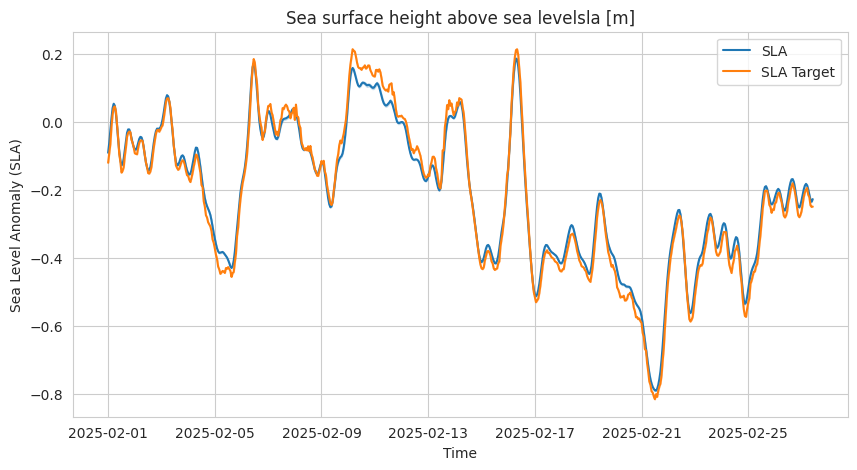

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for Seaborn
sns.set_style("whitegrid")

# Erstellen der Plot-Figur
plt.figure(figsize=(10, 5))

# Plot der SLA-Daten
sns.lineplot(x=df_merged["time"], y=df_merged["sla"], label="SLA")

# Plot der SLA Target-Daten
sns.lineplot(x=df_merged["time"], y=df_merged["sla_target"], label="SLA Target")

# Achsen und Titel setzen
plt.title("Sea surface height above sea levelsla [m]")
plt.xlabel("Time")
plt.ylabel("Sea Level Anomaly (SLA)")

# Legende anzeigen
plt.legend()

# Diagramm anzeigen
plt.show()


## Stationary

In [11]:
# df_target = df_merged["sla_target"]

# rolling_mean = df_target.rolling(window = 7).mean(numeric_only=True)
# rolling_std = df_target.rolling(window = 7).std(numeric_only=True)
# plt.plot(df_target, color = 'blue', label = 'Original')
# plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
# plt.plot(rolling_std, color = 'black', label = 'Rolling Std')
# plt.legend(loc = 'best')
# plt.title('Rolling Mean & Rolling Standard Deviation')
# plt.show()

In [12]:

"""
from statsmodels.tsa.stattools import adfuller
def print_df_stats(series, order):
    x=series
    if (order>0):
        x=x.diff(order)[order:]
    result = adfuller(x)
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

print_df_stats(df_target, 0)
print_df_stats(df_target, 1)
"""

"\nfrom statsmodels.tsa.stattools import adfuller\ndef print_df_stats(series, order):\n    x=series\n    if (order>0):\n        x=x.diff(order)[order:]\n    result = adfuller(x)\n    print('ADF Statistic: {}'.format(result[0]))\n    print('p-value: {}'.format(result[1]))\n    print('Critical Values:')\n    for key, value in result[4].items():\n        print('\t{}: {}'.format(key, value))\n\nprint_df_stats(df_target, 0)\nprint_df_stats(df_target, 1)\n"

In [13]:
# from statsmodels.tsa.stattools import acf, pacf

# diff_series=df_target.diff(2)[2:]

# lag_acf=acf(diff_series, nlags=7)
# lag_pacf=pacf(diff_series, nlags=7, method='ols')
# plt.figure(figsize=(20,10))
# plt.subplot(121)
# plt.plot(lag_acf)
# plt.axhline(y=0,linestyle='--',color='green')
# plt.axhline(y=-1.96/np.sqrt(len(diff_series)),linestyle='--',color='green')
# plt.axhline(y=1.96/np.sqrt(len(diff_series)),linestyle='--',color='green')
# plt.title('Autocorrelation Function')
# plt.subplot(122)
# plt.plot(lag_pacf)
# plt.axhline(y=0,linestyle='--',color='green')
# plt.axhline(y=-1.96/np.sqrt(len(diff_series)),linestyle='--',color='green')
# plt.axhline(y=1.96/np.sqrt(len(diff_series)),linestyle='--',color='green')
# plt.title('Partial Autocorrelation Function')

In [14]:
cols = [col for col in df_merged.columns if df_merged[col].dtype in [np.float64, np.float32]]
cols

['depth',
 'latitude',
 'longitude',
 'bottomT',
 'mlotst',
 'siconc',
 'sithick',
 'sla',
 'so',
 'sob',
 'thetao',
 'uo',
 'vo',
 'wo',
 'latitude_target',
 'longitude_target',
 'sla_target']

## Transform Data to 2D-Array

In [15]:

# Assuming 'df' is your DataFrame
df = df_merged.copy()
# 1. Convert time to datetime (if not already)
df['time'] = pd.to_datetime(df['time'])

# Round latitudes and longitudes
df['latitude'] = df['latitude']
df['longitude'] = df['longitude']

# 2. Get unique time points (hourly)
unique_times = df['time'].dt.strftime('%Y-%m-%d %H:00:00').unique()

df = df.drop(columns=["sla_target", "sla", "latitude_target", "longitude_target"])
target = df_merged["sla_target"]

display(df.head(3))
display(df.info())

print(f'Number of Unique latituds: {len(df["latitude"].unique())}')
print(f'Number of Unique longitudes: {len(df["longitude"].unique())}')

# 3. Create function to map lat/lon to grid coordinates
def map_coordinates_to_grid(df):
    # Get unique latitudes and longitudes
    latitudes = df['latitude'].unique()
    longitudes = df['longitude'].unique()

    # Create a grid, map latitude/longitude to a 2D grid
    latitude_map = {lat: idx for idx, lat in enumerate(latitudes)}
    longitude_map = {lon: idx for idx, lon in enumerate(longitudes)}
    #print(latitude_map)
    return latitude_map, longitude_map, len(latitudes), len(longitudes)

# 4. Create RGB image for each hour
def create_image_for_time(df, latitude_map, longitude_map, img_height, img_width):


    # get cols wich are numerical
    cols = [col for col in df.columns if df[col].dtype in [np.float64, np.float32]]

    # Remove latitude and longitude from cols
    cols.remove('latitude')
    cols.remove('longitude')
    #print(cols)

    # Normalize the values of uo, wo, and vo to [0, 255]
    #scaler = MinMaxScaler((0, 255))
    #df[cols] = scaler.fit_transform(df[cols])

    # Initialize a 2D array for every feature
    image = np.zeros((img_height, img_width, len(cols)), dtype=np.float32)

    for _, row in df.iterrows():
        #print(row)
        #print(row['latitude'])
        lat_idx = latitude_map[row['latitude']]
        lon_idx = longitude_map[row['longitude']]

        # Assign values of the cols to the corresponding pixel
        for col in cols:
            image[lat_idx, lon_idx, cols.index(col)] = row[col]

    return image

learning_data = {}
# 5. Loop through each unique time point and create an image
for i, time_point in tqdm(enumerate(unique_times), desc='Creating 2D-Array Data', total=len(unique_times)):
    # Filter data for the given time
    time_data = df[df['time'].dt.strftime('%Y-%m-%d %H:00:00') == time_point]

    # Map coordinates to grid
    latitude_map, longitude_map, img_height, img_width = map_coordinates_to_grid(time_data)

    # Create RGB image for this timepoint
    image = create_image_for_time(time_data, latitude_map, longitude_map, img_height, img_width)

    learning_data[time_point] = np.array(image)

    """
    # Save or display the image
    plt.imshow(image)
    plt.title(f'Image for {time_point}')
    plt.axis('off')  # Turn off axis labels
    #plt.savefig(f'image_{time_point}.png')  # Save the image
    plt.show()
    """

    #print(image.shape)
    if i >= 100:
      break

,time,depth,latitude,longitude,bottomT,mlotst,siconc,sithick,so,sob,thetao,uo,vo,wo
0,2025-02-01 00:00:00,0.501646,54.308277,10.708242,3.949874,11.431097,0.0,0.0,20.076197,20.076197,3.949874,0.0,-0.003346,-1.130791e-06
1,2025-02-01 01:00:00,0.501646,54.308277,10.708242,3.947661,11.449051,0.0,0.0,20.077806,20.077806,3.947661,0.0,-0.004077,-7.328313e-07
2,2025-02-01 02:00:00,0.501646,54.308277,10.708242,3.945188,11.472710,0.0,0.0,20.080185,20.080185,3.945187,0.0,-0.007542,-3.588450e-07


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 678815 entries, 0 to 678814
Data columns (total 14 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   time       678815 non-null  datetime64[ns]
 1   depth      678815 non-null  float32       
 2   latitude   678815 non-null  float32       
 3   longitude  678815 non-null  float32       
 4   bottomT    678815 non-null  float32       
 5   mlotst     678815 non-null  float32       
 6   siconc     678815 non-null  float32       
 7   sithick    678815 non-null  float32       
 8   so         678815 non-null  float32       
 9   sob        678815 non-null  float32       
 10  thetao     678815 non-null  float32       
 11  uo         678815 non-null  float32       
 12  vo         678815 non-null  float32       
 13  wo         678815 non-null  float32       
dtypes: datetime64[ns](1), float32(13)
memory usage: 38.8 MB


None

Number of Unique latituds: 40
Number of Unique longitudes: 38


Creating 2D-Array Data:  16%|█▌        | 100/635 [03:47<20:18,  2.28s/it]


In [16]:
print(len(learning_data))

101


In [17]:
learning_data = list(learning_data.values())
learning_data = np.array(learning_data)
print(learning_data.shape)

(101, 40, 38, 11)


In [19]:
number_of_data_points = len(learning_data)
print(number_of_data_points)

image_heigt = learning_data.shape[1]
print(image_heigt)

image_width = learning_data.shape[2]
print(image_width)

number_of_features = learning_data.shape[3]
print(number_of_features)

101
40
38
11


In [20]:
learning_data_flattened = learning_data.reshape(number_of_data_points, -1)
print(learning_data_flattened.shape)

(101, 16720)


In [25]:
# create sliding windows with according target variables
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)


# create the machine learning experimental setup (scale data, create sliding windows, split into train-, validation-, and test-data
def setup_experiment(dataset, seq_len, test_share, val_share, scaler, ignored_last_day):
    scaled_data = scaler.fit_transform(dataset)
    x, y = sliding_windows(scaled_data, seq_len)
    used_vec_length=len(y) - ignored_last_day # remove the last ignored_last_month month
    test_size = int(used_vec_length * test_share)
    val_size = int(used_vec_length * val_share)
    train_size=used_vec_length-test_size-val_size
    index_val_start=train_size
    index_test_start=train_size+val_size
    x_train=x[0:index_val_start]
    y_train=y[0:index_val_start]
    x_val =x[index_val_start:index_test_start]
    y_val =y[index_val_start:index_test_start]
    x_test =x[index_test_start:used_vec_length]
    y_test =y[index_test_start:used_vec_length]

    return x_train, y_train, x_val, y_val, x_test, y_test


# Count the number of trainable parameters of model
def count_params(model):
    if isinstance(model, nn.Module):
        return sum(p.numel() for p in model.parameters() if p.requires_grad)
    else:
        return 0

# Add evaluation measures to the dataframe result_df
# NOTE: At this stage, we are working with a differenced time series, thus metrics like mape make no sense!
def add_result(result_df, predictions, model, model_name, criterion, scaler, testY_pred, testY):
    # compute the loss using the given criterion
    loss=criterion(testY_pred, testY)
    result_df.at[model_name, "Test-Loss"] = loss.item()

    # compute loss as the difference between predicted and actual number of passengers
    testY_pred_passengers=scaler.inverse_transform(testY_pred.reshape(-1,1))
    testY_passengers=scaler.inverse_transform(testY.reshape(-1,1))

    abs_passenger_diff=np.sum(abs(testY_pred_passengers-testY_passengers))
    result_df.at[model_name, "Avg. monthly passenger deviation"] = round(abs_passenger_diff/len(testY_passengers),1)
    result_df.at[model_name, "# Parameters"] = int(count_params(model))

    prediction_df=pd.DataFrame(testY_pred_passengers, columns=[model_name])
    if (predictions.empty):
        predictions.reindex_like(prediction_df)
        predictions["actual"] = pd.DataFrame(testY_passengers, columns=["actual"])["actual"]
    predictions[model_name]=prediction_df[model_name]


In [30]:
sc = MinMaxScaler()

# sliding window width is actually a hyperparameter of the training setup
#sliding_window_width=6
sliding_window_width=7

x_train, y_train, x_val, y_val, x_test, y_test = setup_experiment(
    dataset=learning_data_flattened,
    seq_len=sliding_window_width, # sliding window width = 7 days
    test_share=0.2,
    val_share=0.2,
    scaler=sc,
    ignored_last_day=7)  # <-- Seven Days will be ignored

trainX=torch.Tensor(x_train)
trainY=torch.Tensor(y_train)
valX=torch.Tensor(x_val)
valY=torch.Tensor(y_val)
testX=torch.Tensor(x_test)
testY=torch.Tensor(y_test)


print("Dataset shape: ", learning_data_flattened.shape)
print("Training shape: ", trainX.shape, trainY.shape)
print("Validation shape: ", valX.shape, valY.shape)
print("Testset shape: ", testX.shape, testY.shape)

Dataset shape:  (101, 16720)
Training shape:  torch.Size([52, 7, 16720]) torch.Size([52, 16720])
Validation shape:  torch.Size([17, 7, 16720]) torch.Size([17, 16720])
Testset shape:  torch.Size([17, 7, 16720]) torch.Size([17, 16720])


In [27]:
class LstmModel(nn.Module):

    def __init__(self, input_size, hidden_size):
        super(LstmModel, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size

        self.lstm = nn.LSTM(
            input_size=input_size,       # number of features of each input
            hidden_size=hidden_size,     # size of the hidden state and the cell state
            batch_first=True)            # input and output as (batch, seq, feature)

        self.output_layer = nn.Linear(hidden_size, 1)


    def forward(self, x):
        h_0 = torch.zeros(1, x.size(0), self.hidden_size)  # initialize hidden state before each pass

        c_0 = torch.zeros(1, x.size(0), self.hidden_size)  # initialize cell state before each pass

        lstm_output, (h_out, c_out) = self.lstm(x, (h_0, c_0))  # lstm_output (batch,time-steps,hidden_size), h_out (layers,batch,hidden_size)
        return self.output_layer(lstm_output[:,-1,:])  # use only output of last time step


# Train a model using training data
# Evaluate on validation data
# store a checkpoint for the configuration that performed best on validation
def train(model, num_epochs, learning_rate, loss_function, trainX, trainY, valX, valY):
    optimizer=torch.optim.Adam(model.parameters(), lr=learning_rate)
    best_val_loss=float("inf")
    best_model_dict=model.state_dict()
    best_epoch=0

    model.train()

    for epoch in range(num_epochs):
        trainY_pred = model(trainX)  # predict train with the current model
        optimizer.zero_grad()

        train_loss = loss_function(trainY_pred, trainY) # compute the loss ("how bad is our model?")

        train_loss.backward() # propagate the loss backwards through the network

        optimizer.step() # update weights and biases

        with torch.no_grad():
            valY_pred=model(valX)
            val_loss=loss_function(valY_pred,valY)
            if (val_loss<best_val_loss):
                best_val_loss=val_loss
                best_model_dict=copy.deepcopy(model.state_dict())
                best_epoch=epoch

        if epoch % 1000 == 999:
            print("Epoch: %d, loss: %1.5f, val_loss: %1.5f" % (epoch, train_loss.item(), val_loss.item()))
    model.load_state_dict(best_model_dict)
    print("Best Epoch: %d, loss: %1.5f" % (best_epoch, best_val_loss.item()))
    return model

# Use the model to predict for the values in the test set
# Return the prediction
def predict(model, testX):
    model.eval()
    with torch.no_grad():
        return model(testX)

In [28]:
predictions = pd.DataFrame()         # in this dictionary we will store the actual predictions for each model on the test data
result = pd.DataFrame()  # in this dataframe we will store the results of our methods on the test data

In [29]:
torch.manual_seed(0)
activation = torch.nn.ReLU()
criterion = nn.MSELoss() # loss function: mean-squared error for regression

num_epochs = 100
learning_rate = 0.02

lstm_model = LstmModel(input_size=1, hidden_size=2)

lstm_model=train(lstm_model, num_epochs, learning_rate, criterion, trainX, trainY, valX, valY)

testY_pred=predict(lstm_model, testX)
add_result(result, predictions, lstm_model, "LSTM", criterion, sc, testY_pred, testY)

RuntimeError: input.size(-1) must be equal to input_size. Expected 1, got 16720